In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
cell_metrics = loading.load_all_cell_metrics(df.basepath)

sessions = pd.DataFrame()
sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")
].basepath.unique()

sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day27
4,Z:\Data\AYAold\AYA9\day12
...,...
100,Z:\Data\FujisawaS\EE\EE0622fm
101,Z:\Data\FujisawaS\EE\EE0627fm
102,Z:\Data\FujisawaS\EE\EE0705fm
103,Z:\Data\FujisawaS\EE\EE0706fm


## Testing below

In [46]:
basepath = r"Z:\Data\HMC1\day8"

st, cell_metrics = loading.load_spikes(basepath,brainRegion=["CA1","PFC","MEC"])
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(0.1)

ep_df = loading.load_epoch(basepath)
ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

In [251]:
st = st[ep_epochs[0]]
ripple_epochs = ripple_epochs[ep_epochs[0]]

In [224]:
st_par = functions.get_participation(
    st.data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)

In [226]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)

<AxesSubplot:>

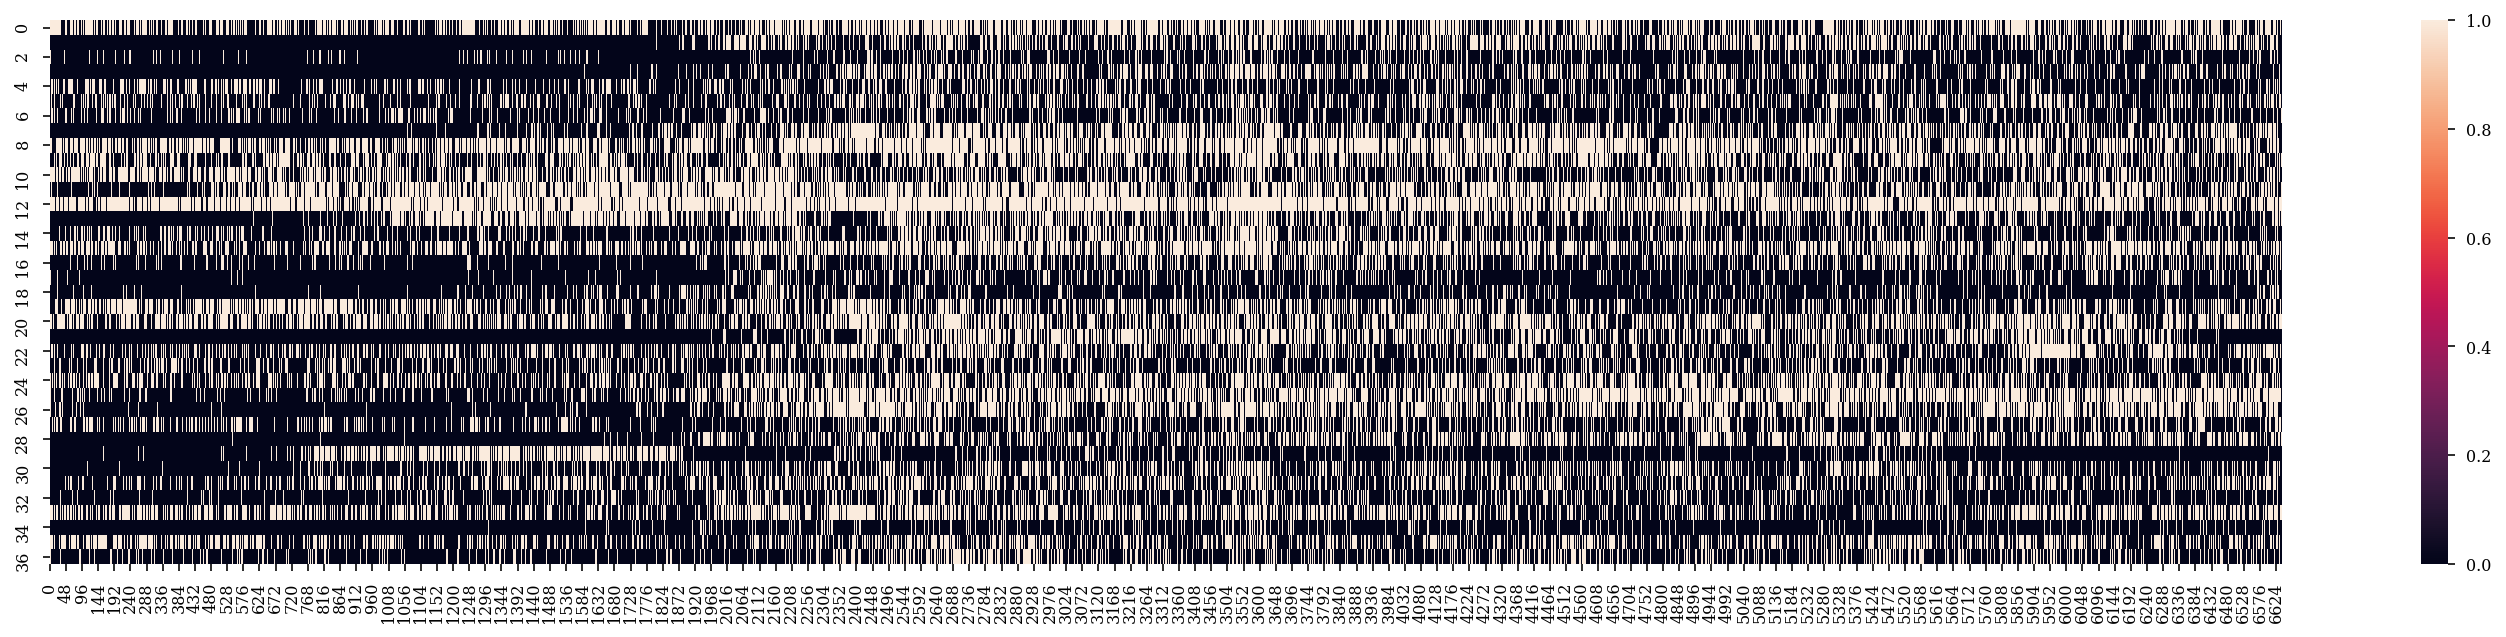

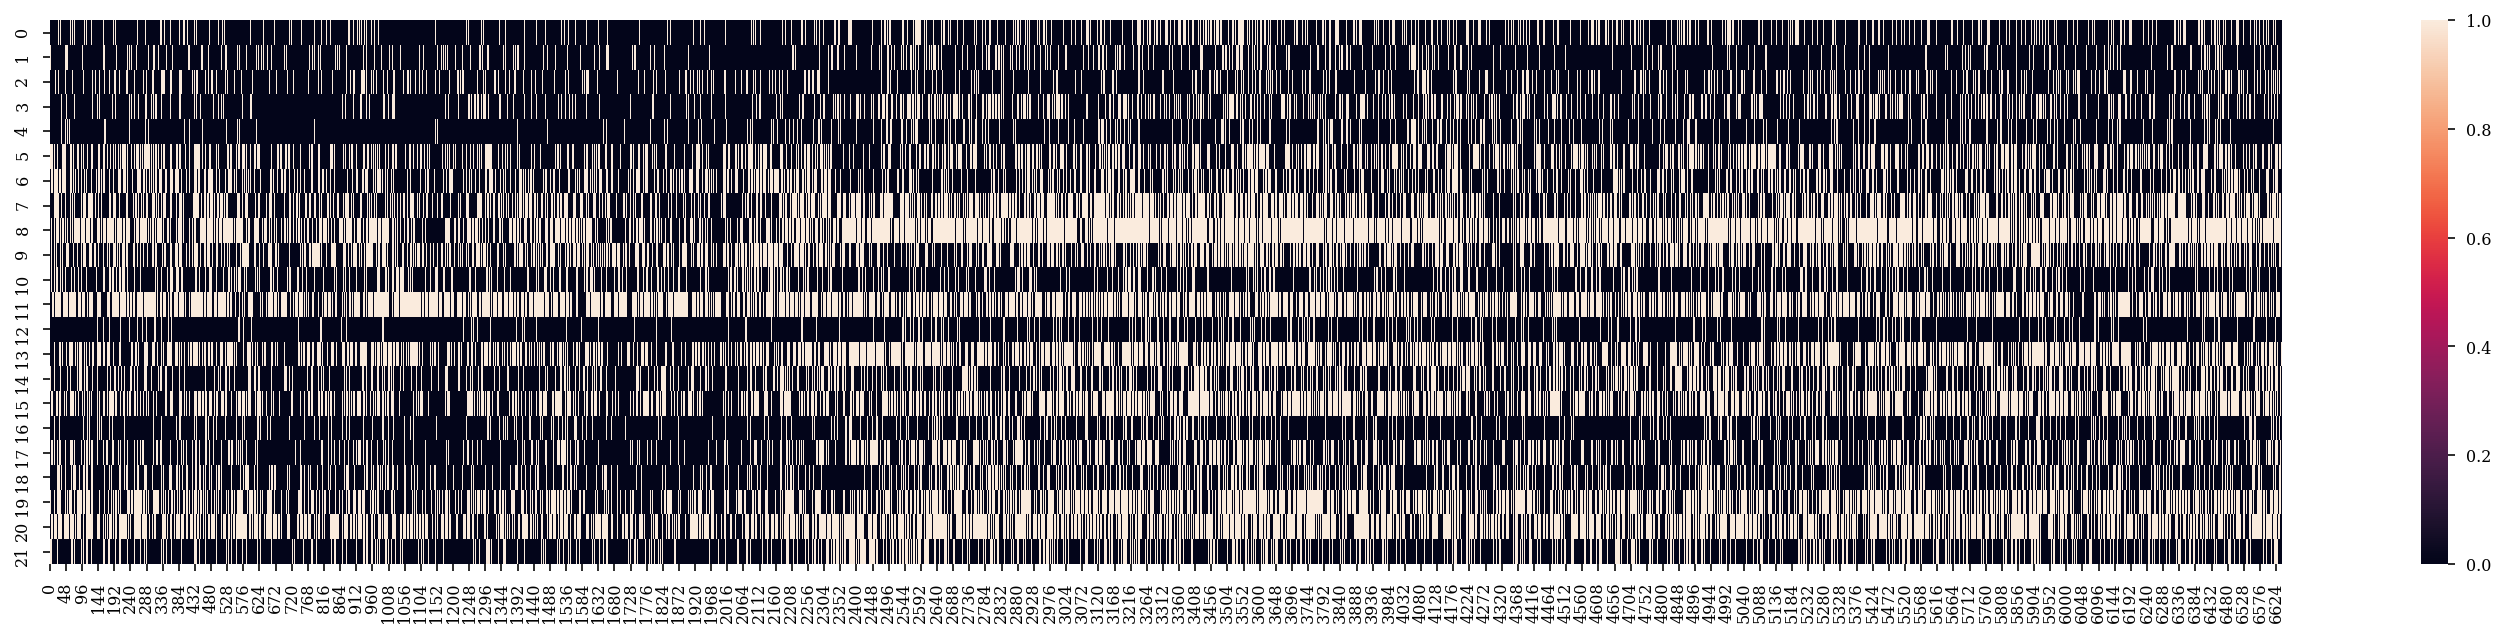

In [228]:
plt.figure(figsize=(25,5))
sns.heatmap(st_par[ca1_deep_idx,:])

plt.figure(figsize=(25,5))
sns.heatmap(st_par[ca1_sup_idx,:])

In [252]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)

ca1_deep_par = functions.get_participation(
    st.iloc[:, ca1_deep_idx].data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)
ca1_sup_par = functions.get_participation(
    st.iloc[:, ca1_sup_idx].data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)
deep_sup_ratio = ca1_deep_par.sum(axis=0) / ca1_sup_par.sum(axis=0)
# deep_sup_ratio = ca1_deep_par.mean(axis=0) / ca1_sup_par.mean(axis=0)
# deep_sup_ratio = (ca1_deep_par.sum(axis=0) - ca1_sup_par.sum(axis=0)) / (ca1_deep_par.sum(axis=0) + ca1_sup_par.sum(axis=0))


In [253]:
pfc_deep_idx = cell_metrics.brainRegion.str.contains("PFC").values
mec_sup_idx = cell_metrics.brainRegion.str.contains("MEC").values

pfc_par = functions.get_participation(st.iloc[:,pfc_deep_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")
mec_par = functions.get_participation(st.iloc[:,mec_sup_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")

In [254]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=10)
X_transformed = embedding.fit_transform(pfc_par.T)

X_transformed.shape

(2332, 10)

<AxesSubplot:>

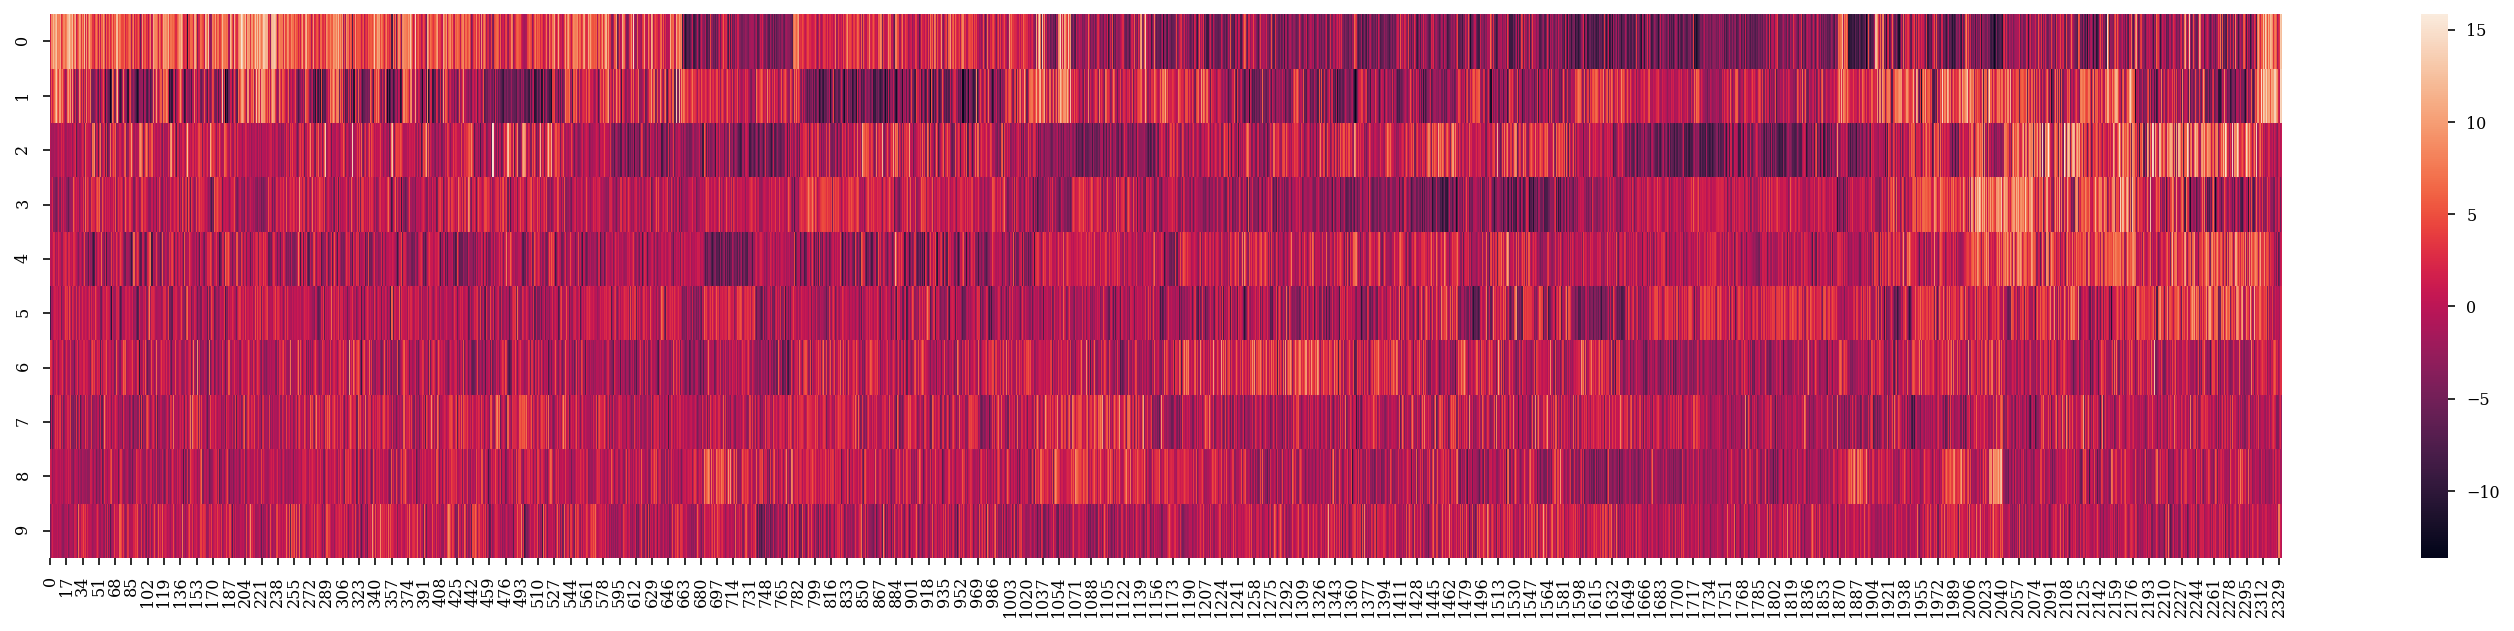

In [255]:
plt.figure(figsize=(25,5))
sns.heatmap(X_transformed.T)

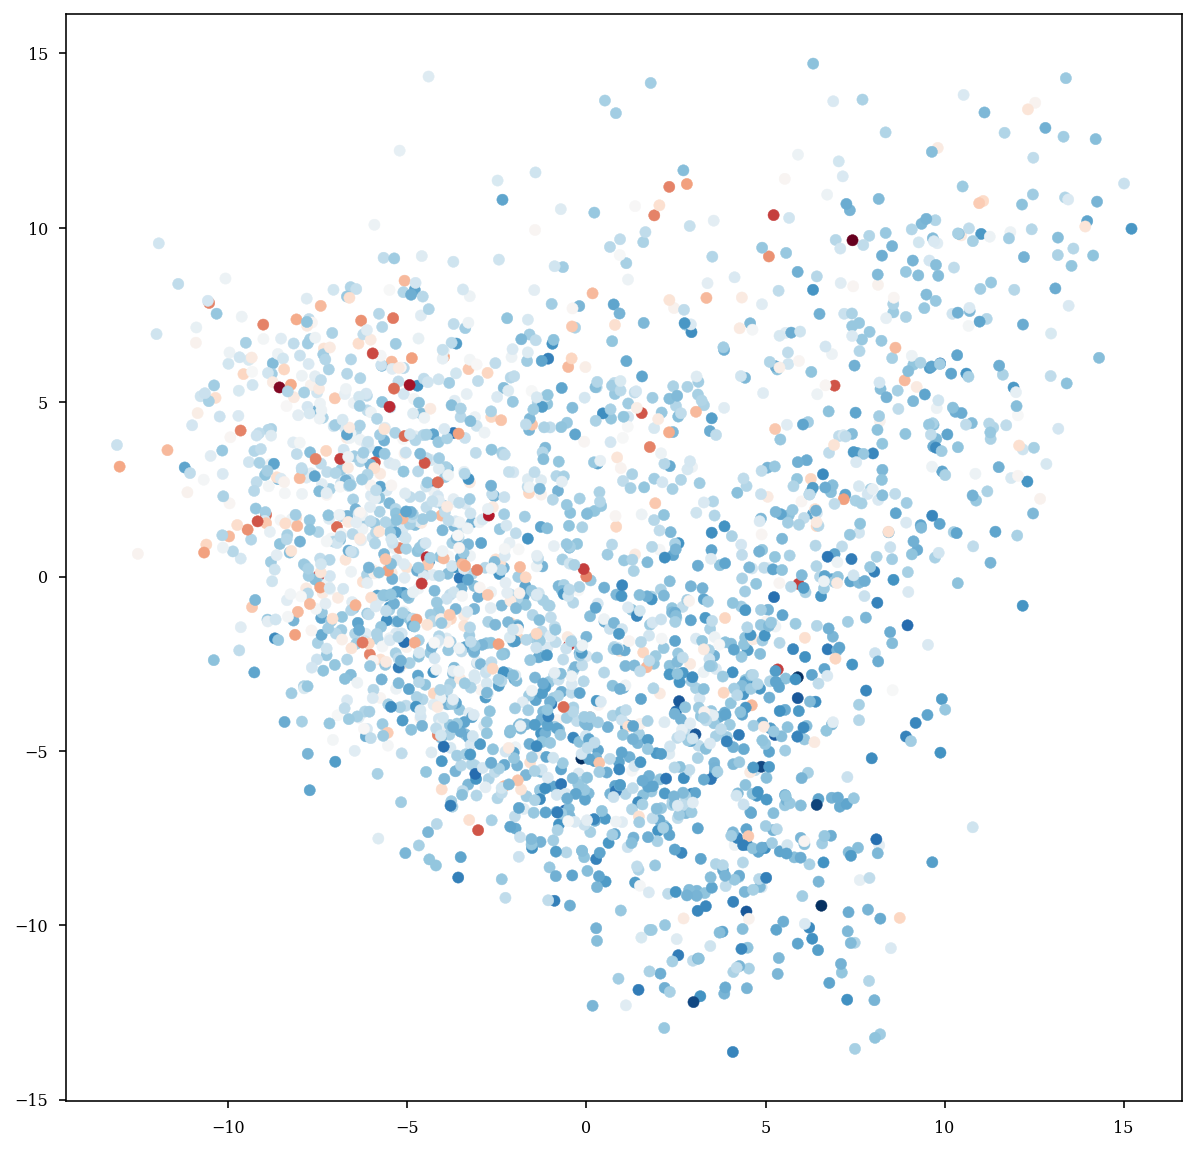

In [256]:
plt.figure(figsize=(10,10))
plt.scatter(X_transformed[:,0],X_transformed[:,1],c=np.log(deep_sup_ratio+1),cmap="RdBu_r")

<AxesSubplot:>

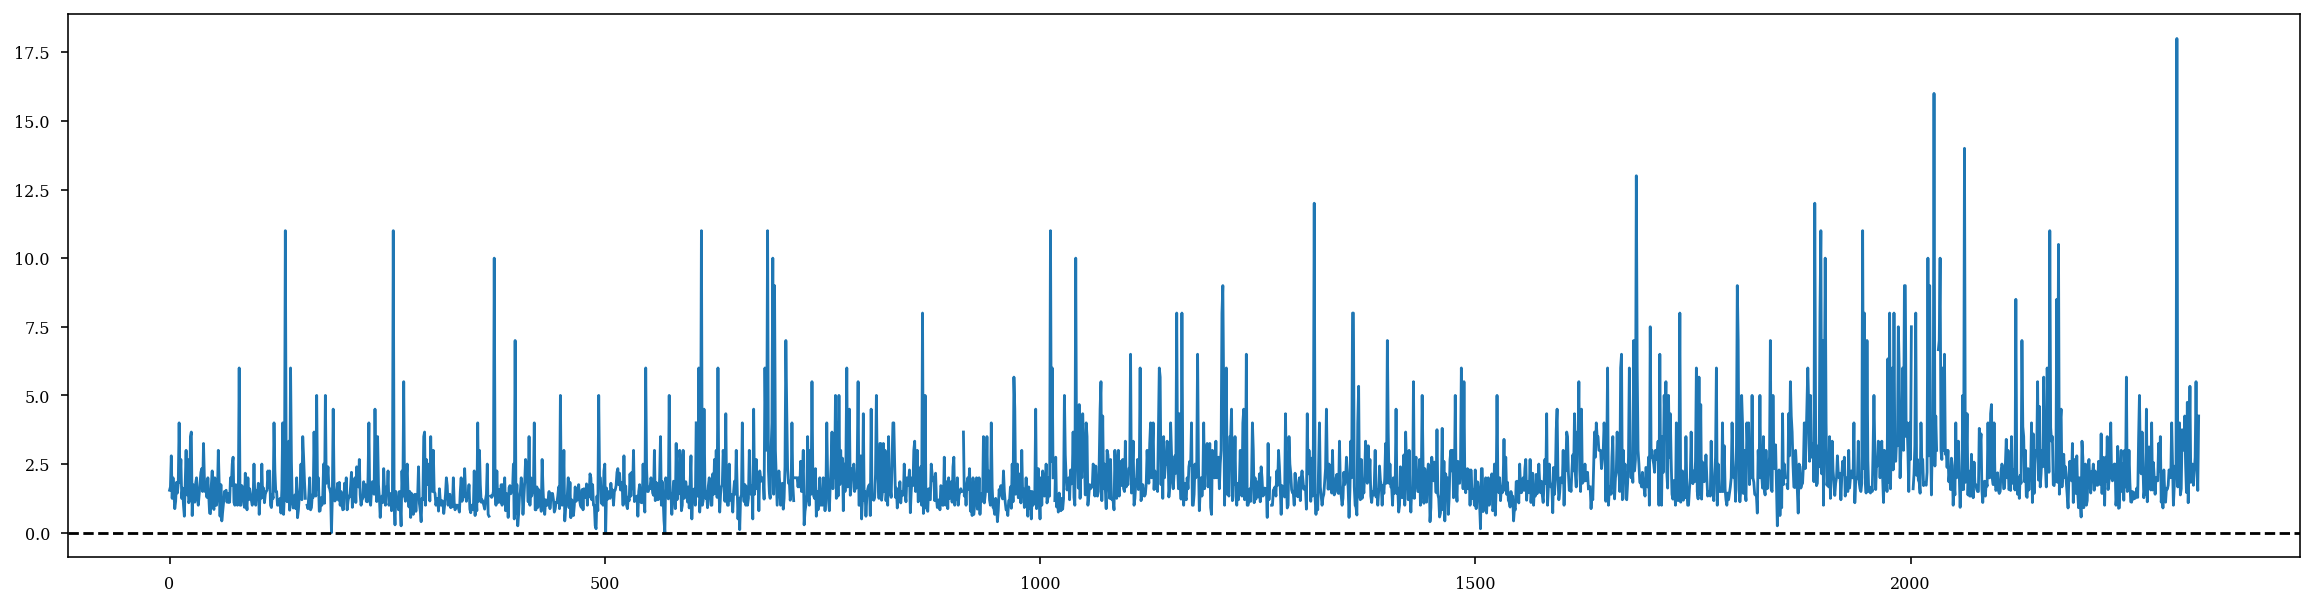

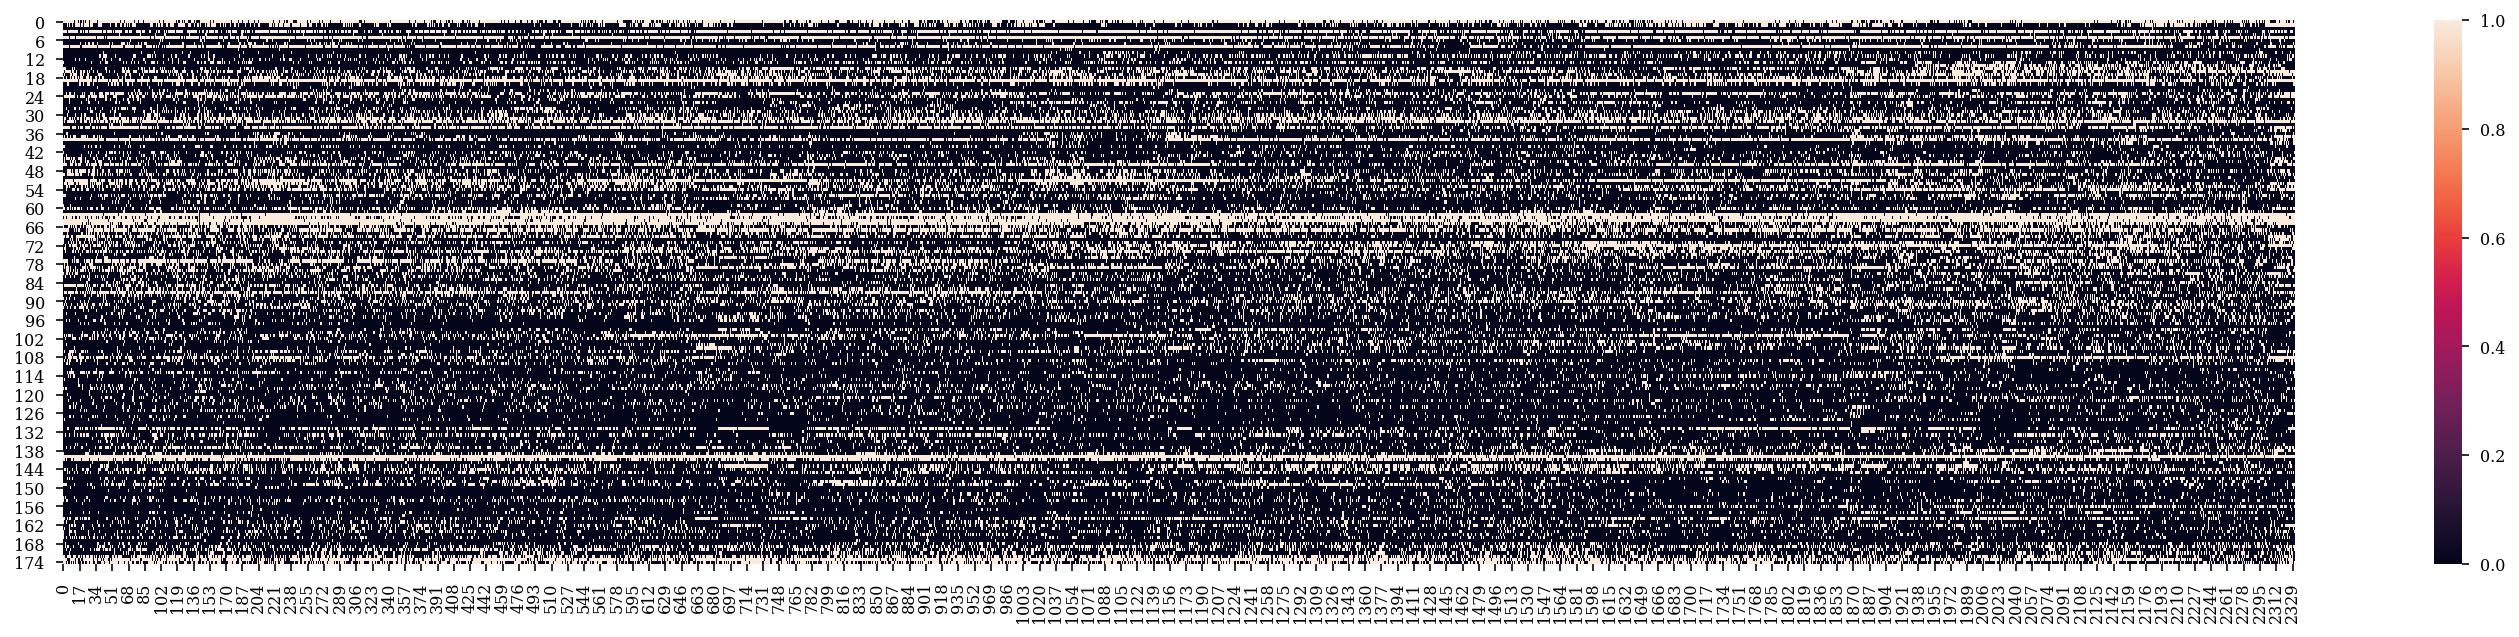

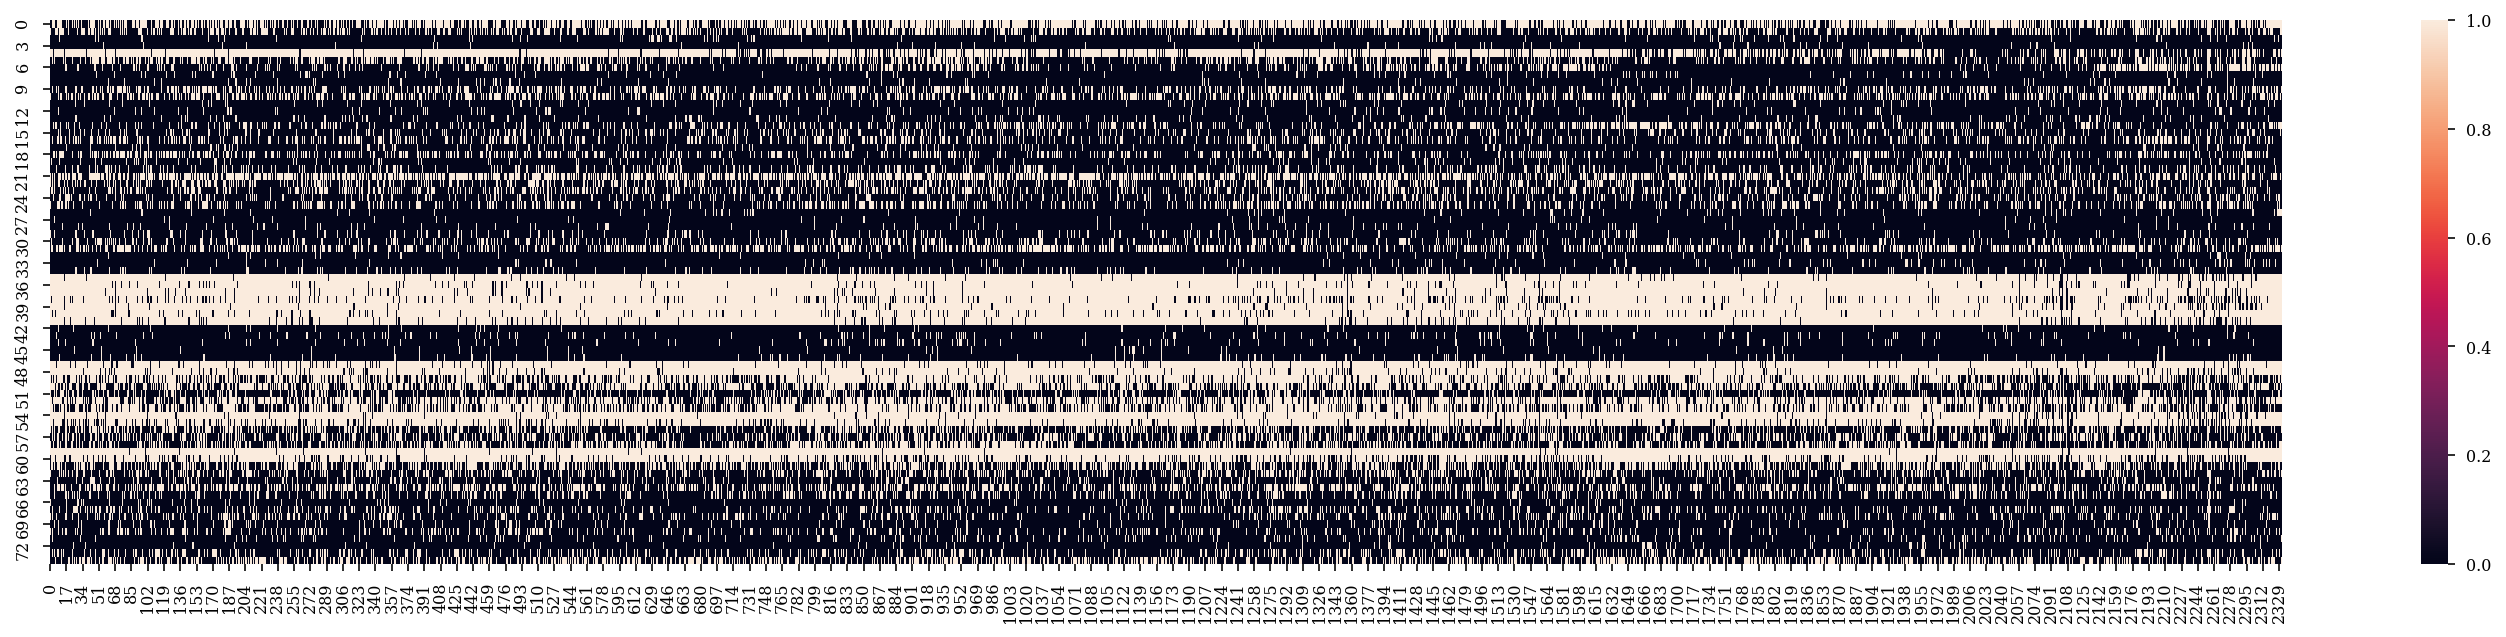

In [257]:
plt.figure(figsize=(20,5))
plt.plot(deep_sup_ratio)
plt.axhline(0,color="k",linestyle="--")
plt.figure(figsize=(25,5))
sns.heatmap(pfc_par)
plt.figure(figsize=(25,5))
sns.heatmap(mec_par)

In [218]:
df = pd.DataFrame(mec_par.T)
# df["mec_par"] = mec_par
df["target"] = deep_sup_ratio
df

corr = df.corr()['target'][df.corr()['target'] < 1].abs()
# corr.sort(ascending=False)
# corr.head()
idx = np.argsort(-corr)

corr[idx]


30    0.077282
31    0.069580
14    0.057998
44    0.054516
50    0.051073
        ...   
57    0.003229
63    0.003182
26    0.002725
12    0.002368
1     0.001518
Name: target, Length: 75, dtype: float64

In [258]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

X = pfc_par.T
X = X_transformed
y = np.log(deep_sup_ratio+1).reshape(-1,1)
# y = deep_sup_ratio.reshape(-1,1)

bad_idx = np.isinf(deep_sup_ratio) | np.isnan(deep_sup_ratio)
y = y[~bad_idx]
X = X[~bad_idx]
# scaler = preprocessing.StandardScaler()
# X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


In [259]:
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_test, y_test))
pred = reg.predict(X_test)

0.1663961951187124


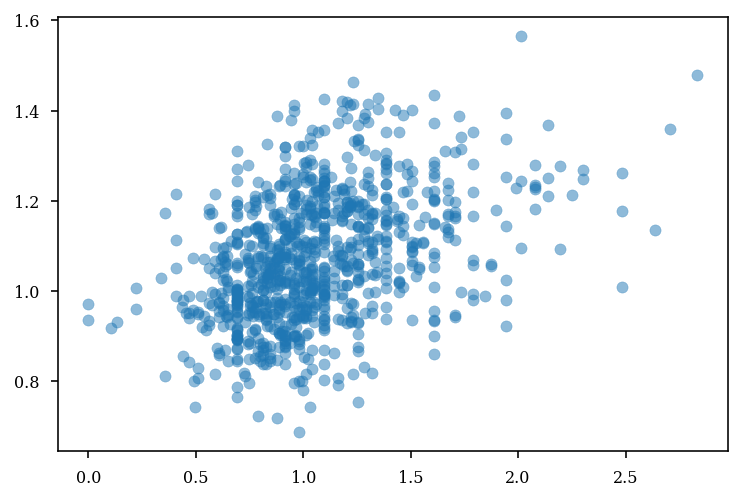

In [260]:
plt.scatter(y_test,pred,alpha=0.5)
# plt.axis("square")
plt.show()

In [261]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

0.11210061683556576

In [262]:
scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[-0.033988   -0.0080605   0.10048346  0.06880007  0.00907027]
0.03 accuracy with a standard deviation of 0.05


In [263]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE

from sklearn.model_selection import GridSearchCV

# set up our search grid
param_grid = {
    "max_depth": [4, 5],
    "n_estimators": [500, 600, 700],
    "learning_rate": [0.01, 0.015],
}

regressor = xgb.XGBRegressor(seed=123, eval_metric="rmsle")

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ", search.best_params_)


The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [264]:
regressor = xgb.XGBRegressor(
    learning_rate=search.best_params_["learning_rate"],
    n_estimators=search.best_params_["n_estimators"],
    max_depth=search.best_params_["max_depth"],
    eval_metric="rmsle",
)

regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)


In [265]:
regressor.score(X_test, y_test)

0.14521109352040396

In [266]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
print("The score is %.5f" % RMSLE )

mse = mean_squared_error(y_test, predictions)
mse

The score is 0.15921


0.11494952772463338

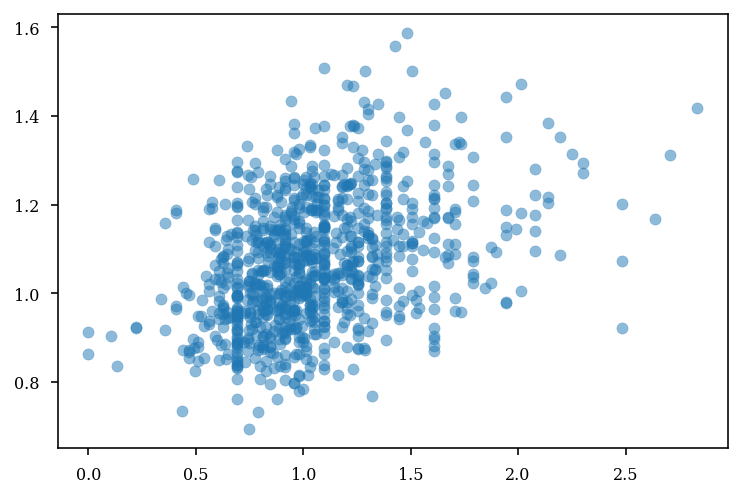

In [267]:
plt.scatter(y_test,predictions,alpha=0.5)
# plt.axis("square")
# plt.xlim(-.5,2.5)
# plt.ylim(-.5,2.5)
plt.show()

In [268]:


model = xgb.XGBRegressor(seed = 123)
# define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
# scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = cross_val_score(model, X, y, cv=5)
# scores = np.abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X_train, y_train)

pred = model.predict(X_test)

Mean MAE: -0.227 (0.085)


In [269]:
score = model.score(X_test, y_test) 
score

-0.0014960693110606105

In [270]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

0.13467828058216744

(0.0, 200.0)

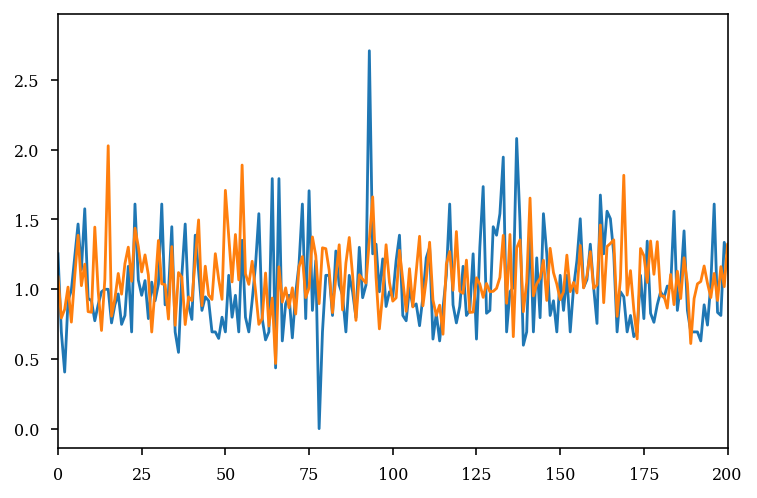

In [271]:
plt.plot(y_test)
plt.plot(pred)
plt.xlim(0,200)

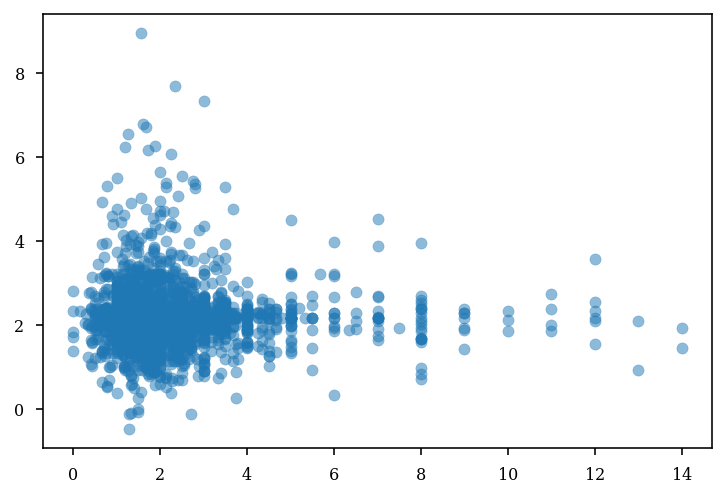

In [ ]:
plt.scatter(y_test,pred,alpha=0.5)
# plt.axis("square")
# plt.xlim(-.5,2.5)
# plt.ylim(-.5,2.5)
plt.show()

In [ ]:
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)
 
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:squarederror"}
 
xgb_r = xgb.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
pred = xgb_r.predict(test_dmatrix)
 
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  0.287747


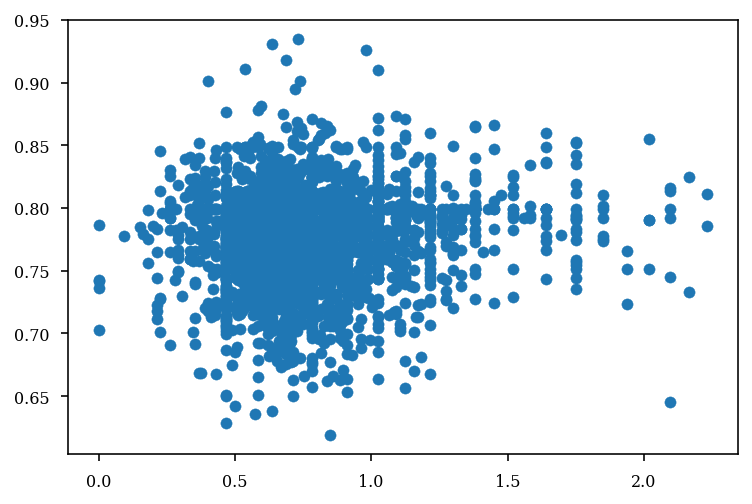

In [ ]:
plt.scatter(y_test,pred)
# plt.axis("square")

In [ ]:
reg = Lasso().fit(X_train, y_train)
reg.score(X_test, y_test)

-6.0279201143709216e-05

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(random_state=0)
reg = BaggingRegressor(extra_tree, random_state=0).fit(
    X_train, y_train)
reg.score(X_test, y_test)

-0.20827310041102876

In [ ]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((2614, 23), (2614, 1), (3920, 23), (3920, 1))

In [ ]:


reg = make_pipeline(preprocessing.StandardScaler(), BaggingRegressor(extra_tree, random_state=0))

scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[-0.25122904 -0.19895562 -0.41078681 -0.20635456 -0.16995342]
-0.25 accuracy with a standard deviation of 0.09


In [136]:
from elephant.causality.granger import pairwise_granger
pairwise_granger(np.random.uniform(size=(1000, 2)), max_order=2)


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\causality\granger.py:494: UserWarning: The value of the log determinant is at or below the tolerance level. Proceeding with computation.


Causality(directional_causality_x_y=0.0, directional_causality_y_x=0.01, instantaneous_causality=0.0, total_interdependence=0.01)

In [167]:
x = np.random.randn(1001)
y = 3.5 * x[:-1] + np.random.randn(1000)
signals = np.array([x[1:], y]).T  # N x 2 matrix
pairwise_granger(signals, max_order=1)

Causality(directional_causality_x_y=2.47, directional_causality_y_x=0.0, instantaneous_causality=0.0, total_interdependence=2.47)

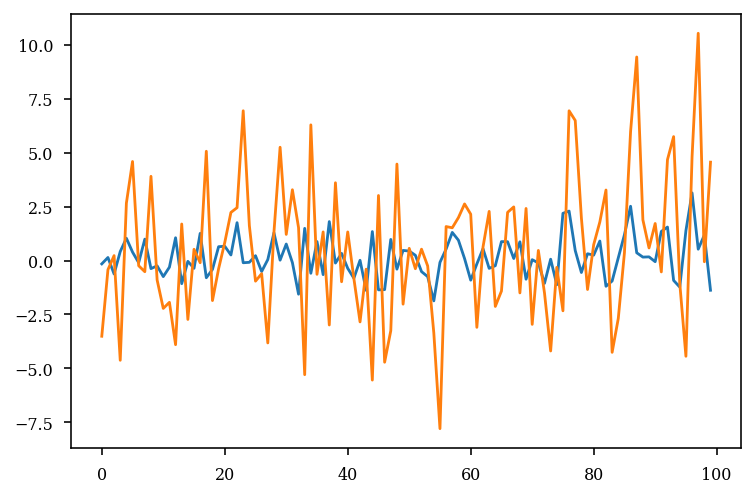

In [174]:
plt.plot(signals[0:100,0])
plt.plot(signals[0:100,1])

In [202]:
directional_causality_x_y = []
for x in X_test.T:
    signals = np.hstack([y_test.reshape(-1,1),x.reshape(-1,1)])
    out = pairwise_granger(signals, max_order=1)
    # signals
    # X_test.shape, y_test.shape
    directional_causality_x_y.append(out.directional_causality_x_y)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\causality\granger.py:494: UserWarning: The value of the log determinant is at or below the tolerance level. Proceeding with computation.


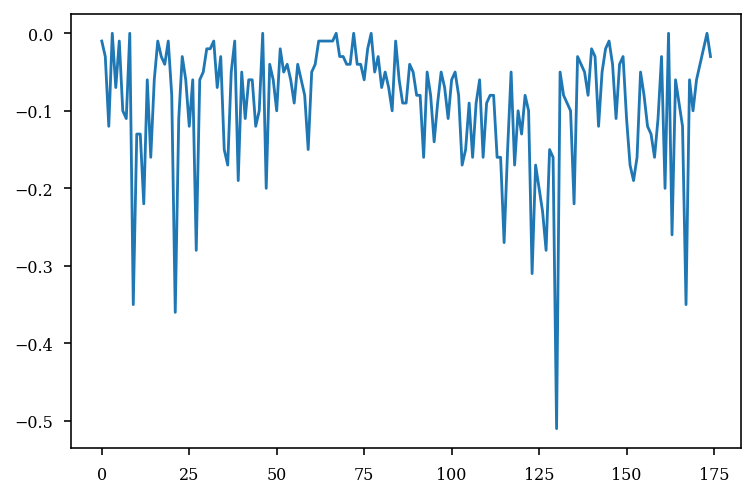

In [204]:
plt.plot(directional_causality_x_y)

(0.0, 100.0)

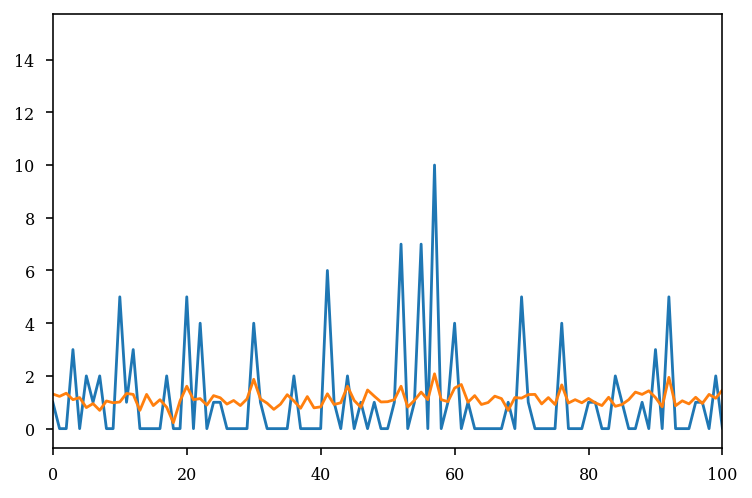

In [215]:
np.argmin(directional_causality_x_y)

    # signals = np.hstack([y_test.reshape(-1,1),.reshape(-1,1)])
plt.plot(X_test[:,np.argmax(directional_causality_x_y)])
plt.plot(y_test)
plt.xlim(0,100)